In [1]:
# Figure 5 and 6
## Synoptic environments associated with the four most frequent Weather Types (WTs) linked to HIPEs in the Alpine region.

In [1]:
library(synoptReg)
library(tidyverse)
library(metR)
library(terra)
library(giscoR)
library(legendry)
library(sf)
library(cptcity)
library(patchwork)

setwd("/mnt/CEPH_PROJECTS/HIPEAtMount/HIPEAtMount-WP1")
source("Script/Functions/theme_plot.R")
borders <- giscoR::gisco_coastallines
borders_coastlines <- giscoR::gisco_get_coastallines(resolution = "20")


****
Welcome to synoptReg! 
Using synoptReg for research publication?  Please cite it!
Lemus-Canovas, M. et al. synoptReg: An R package for computing a synoptic climate classification and a spatial regionalization of environmental data. 
Environmental Modelling & Software 118, 114-119 (2019). DOI: https://doi.org/10.1016/j.envsoft.2019.04.006.
****


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘metR’


The following object is masked from ‘package:purrr’:

    cross


terra 1.8.60


Attaching pa

In [2]:
## ---- Borders & geographic context ----------------------------------------
# Getting Alpine and neighboring borders
borders <- giscoR::gisco_get_countries(country = c(
  "Italy","Switzerland","France","Austria","Slovenia",
  "Germany","Croatia","Bosnia"
), resolution = "03")

# Alpine convention borders
borders_convention <- read_sf("Data/Borders/Alpine_Convention_Perimeter_2018_v2/Alpine_Convention_Perimeter_2018_v2.shp") %>%
  st_transform(crs = st_crs(borders)) %>%
  st_make_valid()

# HISTALP borders
HISTALP_borders <- read_sf("Data/Borders/Shape_CRSM/Shape_CRSM.shp") %>%
  st_transform(crs = st_crs(borders)) %>%
  st_make_valid()

# Intersecting HISTALP with Alpine convention borders
GAR_HISTALP_intersect <- st_intersection(borders_convention, HISTALP_borders) %>% 
  dplyr::select(Id.1) %>% 
  dplyr::rename(Regions = Id.1) %>%
  mutate(
    Regions = ifelse(Regions == 0, "Southwest", Regions),
    Regions = ifelse(Regions == 1, "Northwest", Regions),
    Regions = ifelse(Regions == 2, "Northeast", Regions),
    Regions = ifelse(Regions == 3, "Southeast", Regions)
  )

# Alpine extent
sample_4_extent <- rast("Data/APGD/harmonised/RapdD_al05_19710100_harm.nc")[[1]]
extent <- ext(sample_4_extent)

Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”


In [ ]:
times <- list.files(path = "Data/ERA5/WT_data/",pattern = "MSLP") %>%
      str_remove("MSLP_") %>% str_remove("_EU_dm.nc") %>%
      ymd()
  
# Use terra to read the NetCDF file and assign the extracted dates
msl <- list.files(path = "Data/ERA5/WT_data/",pattern = "MSLP",full.names = T) %>% rast
terra::time(msl) <- times    # Assign the time vector to the SpatRaster object

# Use terra to read the NetCDF file and assign the extracted dates
z500 <- list.files(path = "Data/ERA5/WT_data/",pattern = "Z500",full.names = T) %>% rast
terra::time(z500) <- times    # Assign the time vector to the SpatRaster object

# Convert the SpatRaster to the synoptReg structure
msl_sr <- as_synoptReg(msl/100)  # This step may take some time
z500_sr <- as_synoptReg(z500/9.8)  # This step may take some time

# Step 5: Combine SLP and z500 data, filter for a specific geographic region
vars <- bind_rows(msl_sr,z500_sr) %>%
  filter(time <= "2022-12-31")

cropped_vars_4_clas <- vars%>%  # Combine both datasets
  filter(x >= -5, x <= 25) %>%  # Filter longitude range
  filter(y >= 35, y <= 55)  # Filter latitude range

cropped_vars_4_clas$time %>% unique() %>% length()
# Step 6: Perform Principal Component Analysis (PCA) for dimensionality reduction
info <- pca_decision(cropped_vars_4_clas, ncomp = 30, norm = TRUE, matrix_mode = "T-mode")  
# PCA with up to 30 components, normalization enabled, and T-mode analysis

info$summary # take a look at the explained variance 
info$screeplot +
  scale_y_continuous(breaks = seq(0,1,.2))+
  theme(panel.grid = element_blank())# scree test - 10 pcs get 80 % of the EV.



In [5]:
# Step 7: Perform clustering for synoptic classification
# cl <- clas_t_mode_U(vars, ncomp = 4, norm = T, matrix_mode = "T-mode",Thr_U = .1,cor = T)  
cl <- synoptclas(cropped_vars_4_clas, ncomp = 4, norm = T, matrix_mode = "T-mode")  

# Step 8: Visualization
frequency_cl <- table(cl$clas_pn$WT)

# Order cl WTs by frequency
cl$clas_pn$WT <- factor(cl$clas_pn$WT, levels = names(sort(frequency_cl, decreasing = T)))
write_csv(cl$clas_pn,"Output/Data/3_Predictors/Temporal/weather_types_HIPEs_vol2.csv")

percentage_cl <- round(frequency_cl/sum(frequency_cl) * 100,1)

# Order frequency_cl by frequency
frequency_cl <- frequency_cl[order(frequency_cl, decreasing = T)]

# Order percentage_cl by frequency
percentage_cl <- percentage_cl[order(frequency_cl, decreasing = T)]

# Create a data frame with the frequency and percentage of each WT
WTs_labels <- paste0(levels(cl$clas_pn$WT)," | ", frequency_cl, " (",percentage_cl,"%)")



In [6]:
borders <- rnaturalearth::ne_countries(returnclass = "sf",scale = 50)

# Loading IVT data -----------------------------------------------------------
IVTu <- list.files(path = "Data/ERA5/WT_data/",pattern = "IVTu",full.names = T) %>% rast
IVTv <- list.files(path = "Data/ERA5/WT_data/",pattern = "IVTv",full.names = T) %>% rast

# create two groups (1+,1-,2+,2-) & (3+,3-,4+,4-) -------------------------

first_plots <- levels(cl$clas_pn$WT)[1:4]
second_plots <- levels(cl$clas_pn$WT)[5:8]

subset <- "second"

if(subset == "first"){
  sub <- first_plots
}else{
  sub <- second_plots
}

# Link Z500/msl mean values -----------------------------------------------------------
cl_bigger_domain_avg <- cl$clas_pn %>% inner_join(vars) %>%
  group_by(x,y, WT,var) %>%
  summarise(mean_WT_value = mean(value)) %>%
  ungroup() %>%
  filter(WT %in% sub) 


Joining with `by = join_by(time)`
`summarise()` has grouped output by 'x', 'y', 'WT'. You can override using the
`.groups` argument.


Joining with `by = join_by(time)`
`summarise()` has grouped output by 'x', 'y'. You can override using the
`.groups` argument.
Joining with `by = join_by(time)`
`summarise()` has grouped output by 'x', 'y'. You can override using the
`.groups` argument.
Joining with `by = join_by(time)`
`summarise()` has grouped output by 'x', 'y'. You can override using the
`.groups` argument.
Joining with `by = join_by(x, y, WT)`


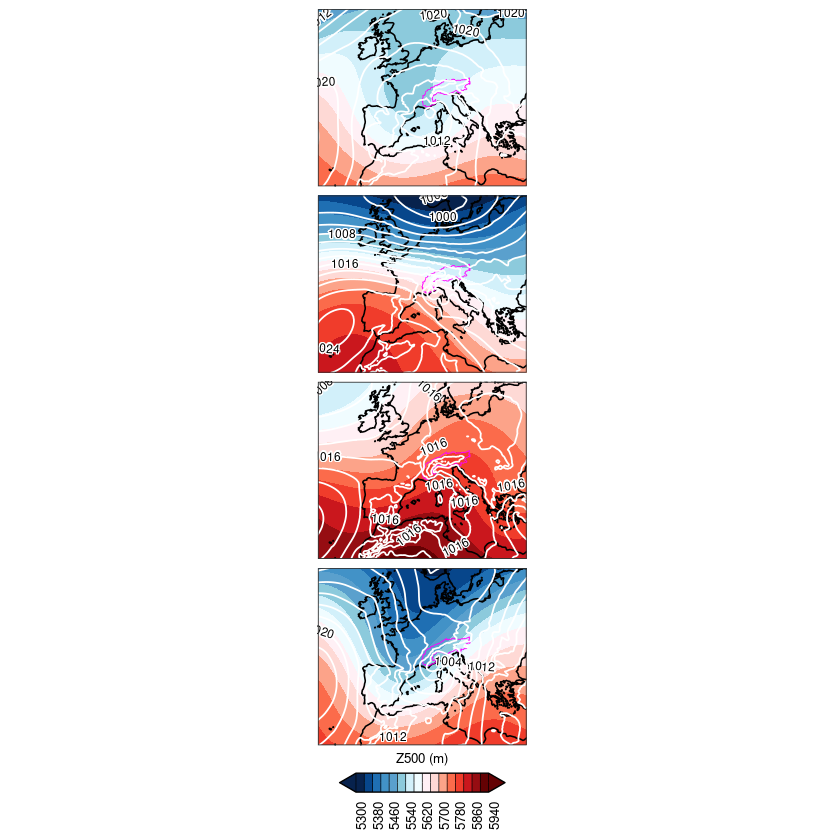

Joining with `by = join_by(time)`
`summarise()` has grouped output by 'x', 'y'. You can override using the
`.groups` argument.
Joining with `by = join_by(time)`
`summarise()` has grouped output by 'x', 'y'. You can override using the
`.groups` argument.
Warning message:
“`stat(level)` was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(level)` instead.”


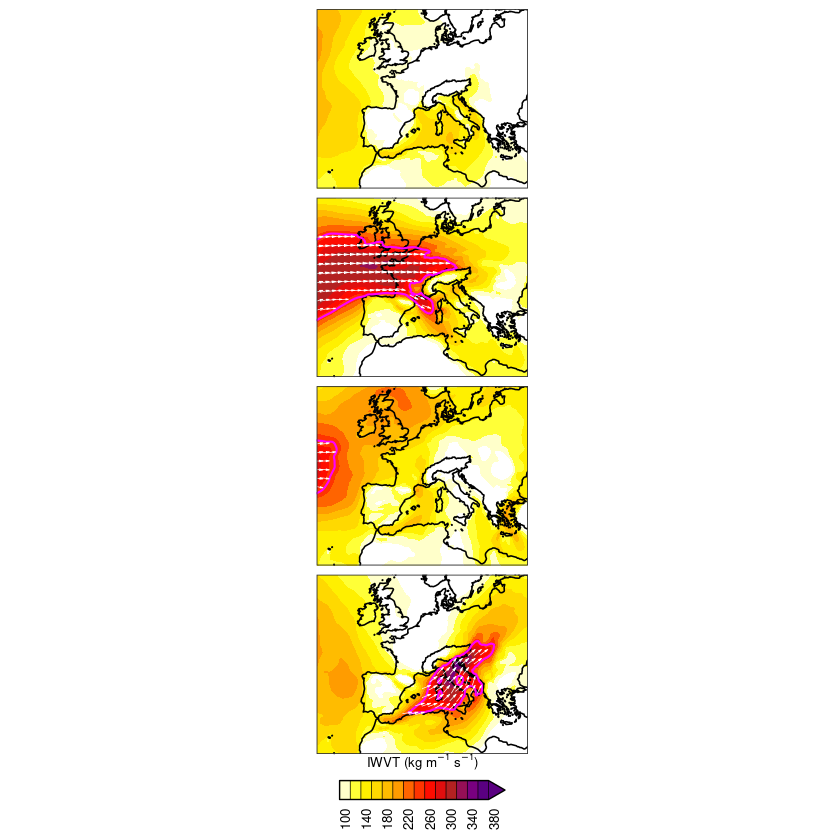

Joining with `by = join_by(time)`
Joining with `by = join_by(lat, lon)`
Warning message in geom_tile(data = cl_epes_pr, aes(lon, lat, fill = Prob_EPE), :
“Ignoring unknown parameters: `breaks`”


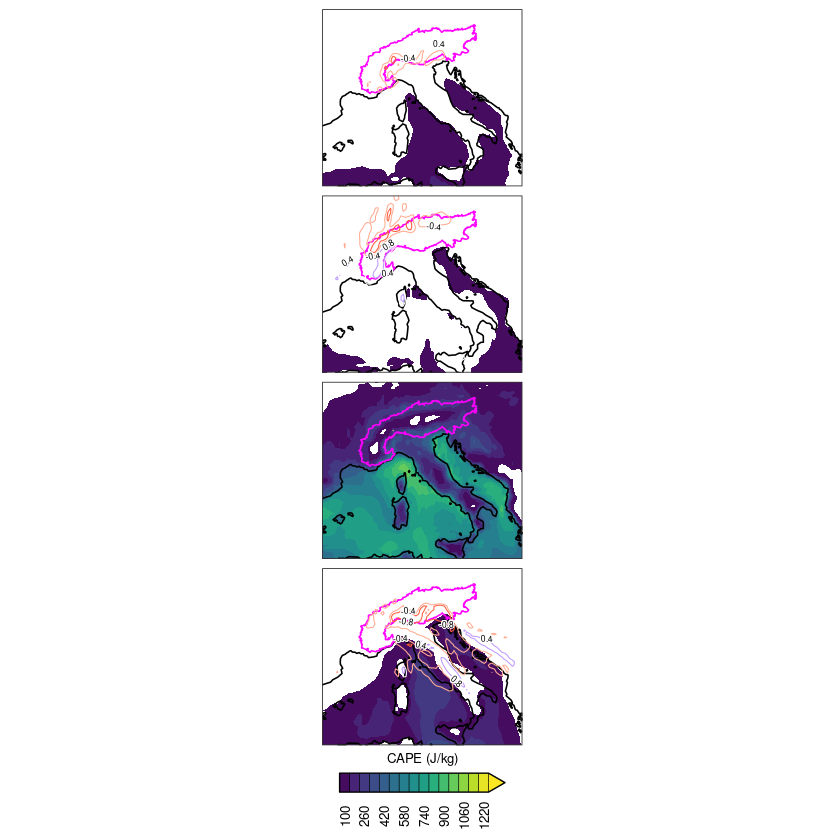

Warning message in plot_theme(plot):
“The `axistexty` theme element is not defined in the element hierarchy.”


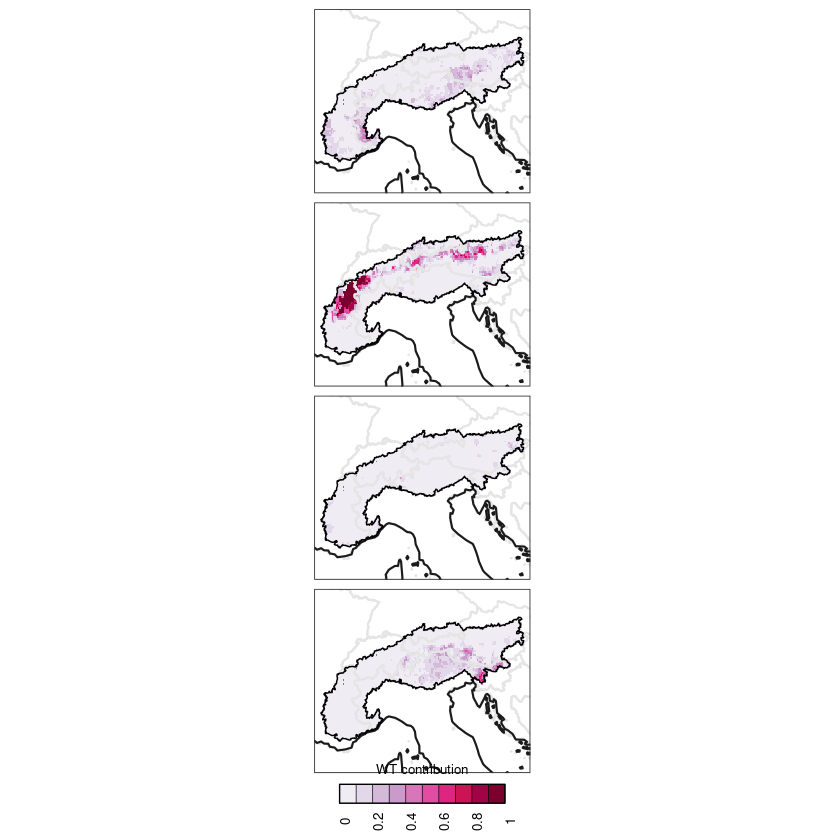

Warning message in plot_theme(plot):
“The `axistexty` theme element is not defined in the element hierarchy.”


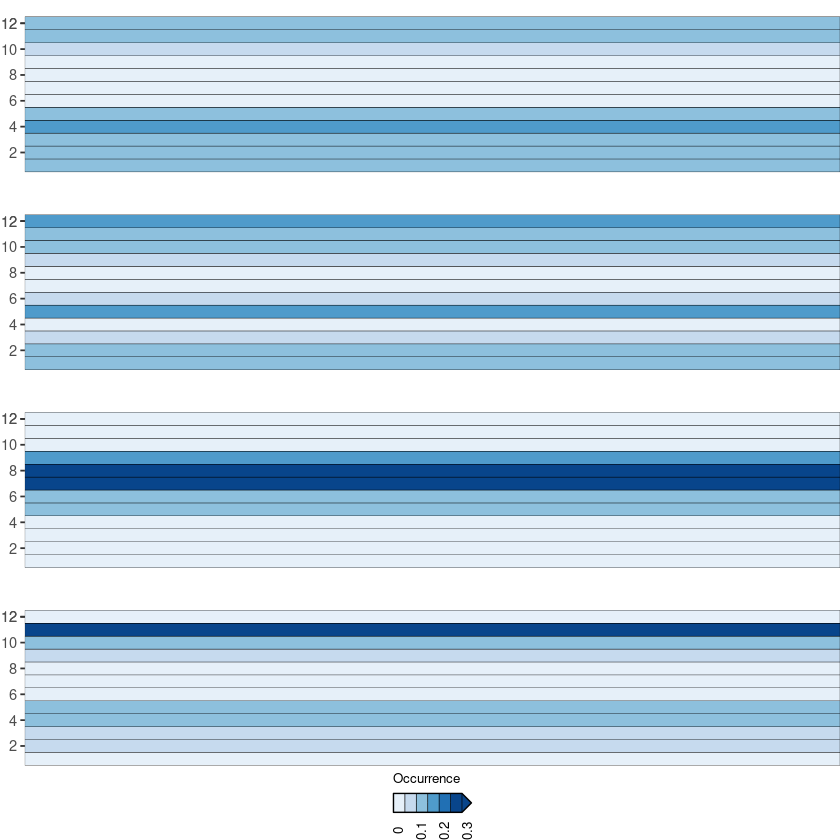

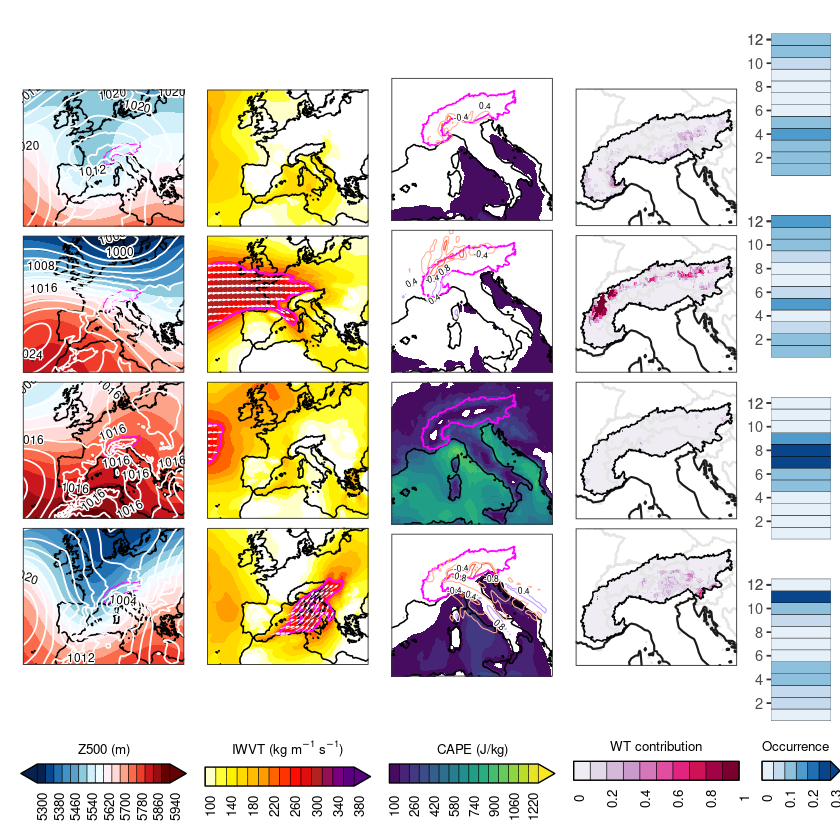

In [7]:

synoptic_palette <- colorRampPalette(c(
  "#8B00FF", # Morat
  "#0000FF", # Blau intens
  "#00FFFF", # Cian
  "#00FF00", # Verd
  "#FFFF00", # Groc
  "#FFA500", # Taronja
  "#FF0000", # Vermell
  "#800000"  # Vermell fosc
))
gradient_colors <- synoptic_palette(100)

breaks_seq <- seq(5300,5940,40)
(z_mslp_plot <- (ggplot()+
  geom_contour_fill(filter(cl_bigger_domain_avg, var == "z"), 
                    mapping = aes(x,y,z = mean_WT_value), # to m
                    breaks = breaks_seq)+
    geom_sf(data = borders_coastlines %>% st_make_valid(), color = "black", linewidth = 0.45,fill = "transparent")+
    geom_sf(data = borders_convention, fill = "transparent", color = "magenta")+
  geom_contour2(data = filter(cl_bigger_domain_avg,var == "msl"),
                aes(x=x,y=y,z=mean_WT_value), 
                binwidth = 2, color = "white",) +
  geom_text_contour(data= filter(cl_bigger_domain_avg, var == "msl"),
                    aes(x=x,y=y,z=mean_WT_value), 
                    stroke = 0.15,binwidth = 4,
                    check_overlap = T,size = 2.5) +
  facet_wrap(~WT, ncol = 1) +
  scale_fill_stepsn(colours = cpt(pal = "ncl_temp_19lev",n = 100), name = "Z500 (m)",
                       guide = guide_colsteps( show = c(TRUE, TRUE), 
                                               oob = "squish"),
                    limits = c(5300,5940),
                    breaks = breaks_seq,
                    labels = ifelse(seq_along(breaks_seq) %% 2 == 0, "", breaks_seq)) +
  scale_x_continuous(limits = c(min(cl_bigger_domain_avg$x),max(cl_bigger_domain_avg$x)), expand = c(0,0))+
  scale_y_continuous(limits = c(min(cl_bigger_domain_avg$y),max(cl_bigger_domain_avg$y)), expand = c(0,0))+
  theme_bw() +
  theme(
    strip.text = element_blank(),
    legend.frame  = element_rect(color = "black",linewidth = 0.4),
    legend.key.height = unit(0.4, "cm"),
    legend.key.width = unit(.7,"cm"),
    legend.ticks.length = unit(c(.2), 'cm'), # different lengths for ticks on both sides
    legend.ticks = element_line(color='black',linewidth = 0.2),    
    panel.grid.major = element_blank(), 
    panel.grid.minor = element_blank(),
    panel.background = element_blank(),
    text = element_text(size = 10),
    strip.background = element_rect(fill = "transparent", color = NA),
    axis.title = element_blank(),
    axis.text = element_blank(),
    axis.ticks = element_blank(),
    legend.text = element_text(angle = 90),
    legend.position = "bottom",
    legend.title.position = "top",
    legend.title = element_text(hjust = 0.5, size = 8),
  legend.margin = margin(t = -10, r = 0, b = 0, l = 0))))

  
# Link IVT mean values -----------------------------------------------------------
IVT <- sqrt(IVTu^2 + IVTv^2) %>%
  `time<-`(times) %>%
  `names<-`(times) %>%
  as.data.frame(xy =T) %>%
  pivot_longer(cols = -c(x,y), names_to = "time", values_to = "value") %>%
  mutate(time = ymd(time)) %>%
  inner_join(cl$clas_pn) %>%
  group_by(x,y,WT) %>%
  summarise(mean = mean(value)) %>%
  filter(WT %in% sub) %>%
  ungroup()

extent2 <- ext(IVTu)

IVTu_m <-IVTu %>%
  `time<-`(times) %>%
  `names<-`(times) %>%
  as.data.frame(xy = T) %>%
  pivot_longer(cols = -c(x,y), names_to = "time", values_to = "value") %>%
  mutate(time = ymd(time)) %>%
  inner_join(cl$clas_pn) %>%
  group_by(x,y,WT) %>%
  summarise(U_mean = mean(value)) %>%
  filter(WT %in% sub)

IVTv_m <-IVTv %>%
  `time<-`(times) %>%
  `names<-`(times) %>%
  as.data.frame(xy = T) %>%
  pivot_longer(cols = -c(x,y), names_to = "time", values_to = "value") %>%
  mutate(time = ymd(time)) %>%
  inner_join(cl$clas_pn) %>%
  group_by(x,y,WT) %>%
  summarise(V_mean = mean(value)) %>%
  filter(WT %in% sub)

# Calcular la direcció del vent
IVTuv_m <- inner_join(IVTu_m,IVTv_m) %>%
  bind_cols(select(IVT,mean))

ivt_colors <- colorRampPalette(c("#4B0082",  # Morat fosc
                                 "#800080",  # Morat
                                 "#B22222",  # Vermell fosc
                                 "#FF0000",  # Vermell
                                 "#FF4500",  # Taronja fosc
                                 "#FFA500",  # Taronja clar
                                 "#FFD700",  # Groc fosc
                                 "#FFFF00",  # Groc brillant
                                 "#FFFFFF"   # Blanc
))

# IVT palette
ivt_palette <- ivt_colors(100) # 10 colors per a una paleta suau

breaks_seq <- seq(100,380,20)

(ivt_plot <- ggplot()+
  geom_sf(data = borders_coastlines, color = "white", linewidth = 0.6,fill = "white")+
  geom_contour_fill(data = IVT, 
                    aes(x,y,z = mean),breaks = breaks_seq)+
  facet_wrap(~WT,ncol = 1)+
    geom_sf(data = borders_coastlines %>% st_make_valid(), color = "black", linewidth = 0.45,fill = "transparent")+
    geom_sf(data = borders_convention, fill = "transparent", linewidth = 0.4, color = "black")+
  scale_fill_stepsn(colours = c("white",rev(ivt_palette)), name = expression("IWVT" ~ "(" * kg * " " * m^{-1} * " " * s^{-1} * ")"),
                    guide = guide_colsteps( show = c(FALSE, TRUE), 
                                            oob = "squish"),na.value = "white",
                    limits = c(100,380),
                    breaks = breaks_seq,
                    labels = ifelse(seq_along(breaks_seq) %% 2 == 0, "", breaks_seq)) +
  geom_contour2(data = IVT, 
                aes(x, y, z = mean), 
                breaks = c(250),           # Threshold at 300
                color = "magenta",           # Contour color
                linewidth = 0.6,                # Line thickness
                linetype = "solid") +
    geom_arrow(data = filter(IVTuv_m, mean > 250), aes(x,y, 
                                   dx = dlon(U_mean, y), 
                                   dy = dlat(V_mean),
                                   mag = mean), 
               skip.x = 5, skip.y = 5, pivot = 0,
               arrow.length = .2,size = .2,
               arrow.ends = "first", arrow.type = "closed",
               color = "white",show.legend = F) +
    scale_mag(limits = c(2,12))+
    scale_x_continuous(limits = c(min(IVT$x),max(IVT$x)), expand = c(0,0))+
  scale_y_continuous(limits = c(min(IVT$y),max(IVT$y)), expand = c(0,0))+
  theme_bw() +
  theme(
    strip.text = element_blank(),
    legend.frame  = element_rect(color = "black",linewidth = 0.4),
    legend.key.height = unit(0.4, "cm"),
    legend.key.width = unit(.7,"cm"),
    legend.ticks.length = unit(c(.2), 'cm'), # different lengths for ticks on both sides
    legend.ticks = element_line(color='black',linewidth = 0.2),    
    panel.grid.major = element_blank(), 
    panel.grid.minor = element_blank(),
    panel.background = element_blank(),
    text = element_text(size = 10),
    strip.background = element_rect(fill = "transparent", color = NA),
    axis.title = element_blank(),
    axis.text = element_blank(),
    axis.ticks = element_blank(),
    legend.text = element_text(angle = 90),
    legend.position = "bottom",
    legend.title.position = "top",
    legend.title = element_text(hjust = 0.5, size = 8),
    legend.margin = margin(t = -15, r = 0, b = 0, l = 0)))

# Link CAPE mean values -----------------------------------------------------------

CAPE <- list.files(path = "Data/ERA5/WT_data/",pattern = "CAPE",full.names = T) %>% 
  rast %>%
  crop(c(1,21,36.5,49.5)) %>%
  `time<-`(times) %>%
  `names<-`(times) %>%
  as.data.frame(xy =T) %>%
  pivot_longer(cols = -c(x,y), names_to = "time", values_to = "value") %>%
  mutate(time = ymd(time)) %>%
  inner_join(cl$clas_pn) %>%
  group_by(x,y,WT) %>%
  summarise(mean = mean(value)) %>%
  filter(WT %in% sub) 

Omega700 <- list.files(path = "Data/ERA5/WT_data/",pattern = "OMEGA700",full.names = T) %>% 
  rast %>%
  crop(c(1,21,36.5,49.5)) %>%
  `time<-`(times) %>%
  `names<-`(times) %>%
  as.data.frame(xy =T) %>%
  pivot_longer(cols = -c(x,y), names_to = "time", values_to = "value") %>%
  mutate(time = ymd(time)) %>%
  inner_join(cl$clas_pn) %>%
  group_by(x,y,WT) %>%
  summarise(mean = mean(value)) %>%
  filter(WT %in% sub)


cape_colors <- colorRampPalette(c(
  "#4B0082",  # Morat fosc
  "#800080",  # Morat
  "#FF00FF",  # Fúcsia (rosa intens)
  "#FF1493",  # Rosa fosc
  "#FF4500",  # Vermell-taronja
  "#FF0000",  # Vermell brillant
  "#FF8C00",  # Taronja fosc
  "#FFA500",  # Taronja clar
  "#FFD700",  # Groc daurat
  "#FFFF00",  # Groc brillant
  "#ADFF2F",  # Verd groguenc
  "#00FF00",  # Verd brillant
  "#00FA9A",  # Verd menta
  "#00FFFF",  # Cian
  "#1E90FF",  # Blau brillant
  "#0000FF",  # Blau fosc
  "#00008B"   # Blau marí fosc
))

# CAPE Palette
cape_palette <- cape_colors(50)

breaks_seq = seq(100,1300,80)
(cape_plot <- ggplot()+
  # geom_sf(data = borders_countries, fill = "white")+
  geom_contour_fill(data = CAPE, 
                    aes(x,y,z = mean),breaks = breaks_seq)+
  facet_wrap(~WT,ncol = 1)+
  geom_sf(data = borders_coastlines %>% st_make_valid(), color = "black", linewidth = 0.45,fill = "transparent")+
  geom_sf(data = borders_convention, fill = "transparent", linewidth = 0.4, color = "magenta")+
  scale_fill_stepsn(colours = pals::viridis(100), name = "CAPE (J/kg)",
                    guide = guide_colsteps( show = c(FALSE, TRUE), 
                                            oob = "squish"),
                    limits = c(100,1301),
                    breaks = breaks_seq,
                    labels = ifelse(seq_along(breaks_seq) %% 2 == 0, "", breaks_seq)) +
    # ggnewscale::new_scale_colour() +
    scale_color_steps2(low = "red",mid = "white",high = "blue",midpoint = 0, 
                       limits = c(-1.4,1.4),
                       breaks = c(-.8,-0.4,.4,.8))+
    geom_contour2(data = Omega700,show.legend = F,
                  aes(x=x,y=y,z=mean, colour = stat(level)), 
                  breaks = c(-.8,-0.4,.4,.8),linewidth = .3) +
    geom_text_contour(data = Omega700,show.legend = F,
                      aes(x=x,y=y,z=mean), 
                      stroke = 0.15, breaks = c(-.8,-0.4,.4,.8),skip = 0,min.size = 30,
                      check_overlap = T,size = 1.8) +
  scale_x_continuous(limits = c(min(CAPE$x),max(CAPE$x)), expand = c(0,0))+
  scale_y_continuous(limits = c(min(CAPE$y),max(CAPE$y)), expand = c(0,0))+
  theme_bw() +
  theme(
    strip.text = element_blank(),
    legend.frame  = element_rect(color = "black",linewidth = 0.4),
    legend.key.height = unit(0.4, "cm"),
    legend.key.width = unit(.7,"cm"),
    legend.ticks.length = unit(c(.2), 'cm'), # different lengths for ticks on both sides
    legend.ticks = element_line(color='black',linewidth = 0.2),    
    panel.grid.major = element_blank(), 
    panel.grid.minor = element_blank(),
    panel.background = element_blank(),
    text = element_text(size = 10),
    strip.background = element_rect(fill = "transparent", color = NA),
    axis.title = element_blank(),
    axis.text = element_blank(),
    axis.ticks = element_blank(),
    legend.text = element_text(angle = 90),
    legend.position = "bottom",
    legend.title.position = "top",
    legend.title = element_text(hjust = 0.5, size = 8),
    legend.margin = margin(t = -10, r = 0, b = 0, l = 0)))


# Link precipitation maps -------------------------------------------------
epe_db_prmsaw_grid <- read_rds("Output/Data/2_ranking_databases/prmsaw_complete_ranking/prmsaw_EPEdb_Ranking_zthr10_1961-2023_gridded.rds") 
epe_db_prmsaw_grid_thr <- read_rds("Output/Data/2_ranking_databases/prmsaw_complete_ranking/prmsaw_EPEdb_Ranking_threshold_nevents_z10_1961-2023_gridded.rds")
n_events <- cl$clas_pn$time %>% length()

cl_epes_pr <- inner_join(cl$clas_pn,select(epe_db_prmsaw_grid,time,lat,lon,P_H)) %>%
  inner_join(select(epe_db_prmsaw_grid_thr, -Events)) %>%
  group_by(lon,lat) %>%
  mutate(total_EPEs = sum(P_H >= Thr)) %>% # total number of epes per grid cell 
  group_by(lon,lat,WT) %>%
  mutate(N_EPEs_WT = sum(P_H >=Thr)) %>%# how many epes fall in each wt with respect total EPEs
  ungroup() %>%
  mutate(Prob_EPE = N_EPEs_WT/total_EPEs) %>%
  distinct(lon,lat,WT,.keep_all = T) %>%
  filter(WT %in% sub) 


# We are then discarding days without EPEs at grid level
(TP_contr_plot <- ggplot()+
    geom_sf(data = borders_coastlines, color = "white", linewidth = 0.6,fill = "white")+
    geom_tile(data = cl_epes_pr, 
            aes(lon,lat,fill = Prob_EPE),breaks = seq(0,2,.1))+
  geom_sf(data = borders_countries, color = "grey90", linewidth = 0.6,fill = "transparent")+
  geom_sf(data = borders_coastlines%>% st_make_valid(), color = "grey10", linewidth = 0.6,fill = "transparent")+
  geom_sf(data = borders_convention, fill = "transparent", linewidth = 0.4, color = "black")+
    scale_fill_stepsn(colours = pals::brewer.purd(100), 
                    limits = c(0,1),
                    breaks = seq(0,1,.1),
                    labels = c(0,"",.2,"",.4,"",.6,"",.8,"",1),
                    name = "WT contribution",)+
  annotate(
    "text", x = -Inf, y = Inf, label = "(c)", # Position at the upper left corner
    hjust = -1.0, vjust = 35, size = 2.8
  ) +
  facet_wrap(~WT,ncol = 1)+
  labs(y = "Annual precipitation")+
  scale_x_continuous(limits = c(extent[1]+0, extent[2]+0.4), expand = c(0, 0),
                     breaks = seq(6,14,4)) +
  scale_y_continuous(limits = c(extent[3]-1, extent[4]+1), expand = c(0, 0),
                     breaks = seq(44,48,2)) +
    theme_bw() +
      theme(
        strip.text = element_blank(),
        legend.frame  = element_rect(color = "black",linewidth = 0.4),
        legend.key.height = unit(0.4, "cm"),
        legend.key.width = unit(.7,"cm"),
        legend.ticks.length = unit(c(.2), 'cm'), # different lengths for ticks on both sides
        legend.ticks = element_line(color='black',linewidth = 0.2),    
        panel.grid.major = element_blank(), 
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        text = element_text(size = 10),
        strip.background = element_rect(fill = "transparent", color = NA),
        axis.title = element_blank(),
        axis.text = element_blank(),
        axis.ticks = element_blank(),
        legend.text = element_text(angle = 90),
        legend.position = "bottom",
        legend.title.position = "top",
        legend.title = element_text(hjust = 0.5, size = 8),
        legend.margin = margin(t = -20, r = 0, b = 0, l = 0)))

# condition to extract first or last 4 values from WTs_labels based on the subset
if(subset == "first"){
  WTs_labels_sub <- WTs_labels[1:4]
}else{
  WTs_labels_sub <- WTs_labels[5:8]
}

# Calculate relative frequency per month and weather type,if no occurrence in a month set 0
monthly_freqs <- cl$clas_pn %>% 
  mutate(month = month(time)) %>%
  group_by(WT) %>% 
  mutate(n_WT = n()) %>% 
  group_by(WT,month) %>% 
  mutate(n = n()) %>% 
  ungroup() %>% 
  mutate(freq = (n/n_WT)) %>%
  complete(WT,month,fill = list(n = 0)) %>% 
  distinct(WT,month,freq,.keep_all = T) %>%
  complete(WT,month,fill = list(freq = 0)) %>% 
  filter(WT %in% sub)

breaks_seq <- seq(0,.3,.05)

(occurrence_plot <- ggplot(monthly_freqs, aes(x = month, y = 1, fill = freq))+
  geom_tile(color = "black")+
  facet_wrap(~WT,ncol = 1)+
  theme_bw()+
  scale_x_continuous(expand = c(0.1,0.1),breaks = c(seq(2,12,2),12))+
  scale_y_continuous(expand = c(0.00,0.00))+
  scale_fill_stepsn(colours = pals::brewer.blues(100), name = "Occurrence",
                    guide = guide_colsteps( show = c(FALSE, TRUE), 
                                            oob = "squish",
                                            size = unit(0.2,"cm")),
                    limits = c(0,.3),
                    breaks = breaks_seq,
                    labels = ifelse(seq_along(breaks_seq) %% 2 == 0, "", breaks_seq)) +
  coord_flip() +
  theme(legend.position = "bottom",
        legend.title = element_text(size = 8),
        legend.title.position = "top",
        # legend.title = element_blank(),
        axis.title.y = element_blank(),
        legend.text = element_text(size = 8, angle = 90),
        legend.frame  = element_rect(color = "black",linewidth = 0.4),
        legend.key.height = unit(0.4, "cm"),
        legend.key.width = unit(.33,"cm"),
        legend.ticks.length = unit(c(.2), 'cm'), # different lengths for ticks on both sides
        legend.ticks = element_line(color='black',linewidth = 0.2),    
        legend.direction = "horizontal",
        legend.key = element_rect(fill = "white", color = "black", size = 0.1),
        strip.text = element_blank(),
        axis.text.x = element_blank(),
        axistexty = element_text(size = 8),
        axis.title.x = element_blank(),
        axis.ticks.x = element_blank(),
        panel.grid = element_blank(),
        panel.border = element_blank(),
        plot.margin = margin(0, 0, 0, 0),
        legend.margin = margin(t = -20, r = 0, b = 0, l = 0)))


# WTs_labels_sub
(z_mslp_plot + ivt_plot +  cape_plot + TP_contr_plot + occurrence_plot) +
  plot_layout(ncol = 5,widths = c(1,1,1,1,.37)) 